In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=2, IMG_HEIGHT= 512, IMG_WIDTH= 512, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [2]:
#from CNN_model_segmentation import multi_unet_model #Uses softmax 
#from CNN_model_segmentation.py import*
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Resizing images, if needed
SIZE_X = 512 
SIZE_Y = 512
n_classes=3 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("D:\\10 Studies\\Masters\\05_02_Master Thesis\\dataset_512\\train\\img\\"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, 1)       
#         img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [4]:
train_images.shape

(74, 512, 512, 3)

In [5]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("D:\\10 Studies\\Masters\\05_02_Master Thesis\\dataset_512\\train\\mask\\"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        mask = cv2.imread(mask_path, 0)       
#         mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

print("uniques in train masks before", np.unique(train_masks))
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
train_masks[train_masks < 50] = 0
# train_masks[train_masks < 150 & train_masks > 50] = 1
mask = np.logical_and(train_masks < 150, train_masks > 50)
train_masks[mask] = 1
train_masks[train_masks > 150] = 2

uniques in train masks before [  0   1   2   3   4   5   6   7   8   9 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 242 243 244 245 246 247 248
 249 250 251 252 253 254 255]


In [6]:
np.unique(train_masks)#.shape

array([0, 1, 2], dtype=uint8)

In [7]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
print(train_masks_reshaped.shape)
#x = labelencoder.fit(train_masks_reshaped)
#train_masks_reshaped_encoded = labelencoder.transform(x)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


np.unique(train_masks_encoded_original_shape)

(19398656, 1)


C:\Users\madan\anaconda3\envs\mytfenv\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2], dtype=int64)

In [8]:
#keys = labelencoder.classes_
#values = labelencoder.transform(keys)
#dic = dict(zip(keys,values))
#print(dic)

In [9]:
#################################################
train_images = np.expand_dims(train_images, axis=-1)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=-1)

In [10]:
print("train images shape = ",train_images.shape,"\n","train masks shape =", train_masks_input.shape )

train images shape =  (74, 512, 512, 3, 1) 
 train masks shape = (74, 512, 512, 1)


In [11]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [12]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2]


In [13]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))


test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [14]:
print("train masks cat =",train_masks_cat.shape )
print("y_train masks cat =",y_train_cat.shape )
print("test masks cat =",test_masks_cat.shape )
print("y_train masks cat =",y_test_cat.shape )

train masks cat = (52, 512, 512, 3)
y_train masks cat = (52, 512, 512, 3)
test masks cat = (8, 512, 512, 3)
y_train masks cat = (8, 512, 512, 3)


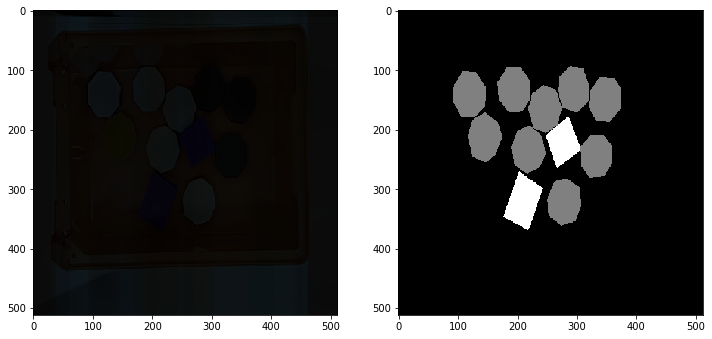

In [15]:
# Sanity check
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (512, 512,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()
#print(X_train[image_number])

In [16]:
###############################################################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [ 0.38314457  3.17912306 13.25082823]


In [17]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=400, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
model.save('unet_shapes_detect.hdf5')
                    


#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

13/13 [==============================] - 40s 3s/step - loss: 0.9012 - accuracy: 0.6640 - val_loss: 0.5222 - val_accuracy: 0.8699
Epoch 2/400
13/13 [==============================] - 39s 3s/step - loss: 0.5008 - accuracy: 0.8675 - val_loss: 0.5631 - val_accuracy: 0.8699
Epoch 3/400
13/13 [==============================] - 40s 3s/step - loss: 0.4358 - accuracy: 0.8682 - val_loss: 0.4404 - val_accuracy: 0.8699
Epoch 4/400
13/13 [==============================] - 41s 3s/step - loss: 0.3841 - accuracy: 0.8682 - val_loss: 0.3641 - val_accuracy: 0.8699
Epoch 5/400
13/13 [==============================] - 41s 3s/step - loss: 0.3363 - accuracy: 0.8682 - val_loss: 0.2715 - val_accuracy: 0.8699
Epoch 6/400
13/13 [==============================] - 42s 3s/step - loss: 0.2516 - accuracy: 0.8682 - val_loss: 0.1920 - val_accuracy: 0.8699
Epoch 7/400
13/13 [==============================] - 43s 3s/step - loss: 0.1821 - accuracy: 0.8682 - val_loss: 0.1765 - val_accuracy: 0.8699
Epoch 8/400
13/13 [======

Epoch 59/400
13/13 [==============================] - 44s 3s/step - loss: 0.0417 - accuracy: 0.9846 - val_loss: 0.0556 - val_accuracy: 0.9797
Epoch 60/400
13/13 [==============================] - 53s 4s/step - loss: 0.0410 - accuracy: 0.9849 - val_loss: 0.0530 - val_accuracy: 0.9805
Epoch 61/400
13/13 [==============================] - 52s 4s/step - loss: 0.0412 - accuracy: 0.9849 - val_loss: 0.0521 - val_accuracy: 0.9810
Epoch 62/400
13/13 [==============================] - 51s 4s/step - loss: 0.0417 - accuracy: 0.9846 - val_loss: 0.0553 - val_accuracy: 0.9798
Epoch 63/400
13/13 [==============================] - 43s 3s/step - loss: 0.0412 - accuracy: 0.9847 - val_loss: 0.0545 - val_accuracy: 0.9802
Epoch 64/400
13/13 [==============================] - 42s 3s/step - loss: 0.0410 - accuracy: 0.9848 - val_loss: 0.0536 - val_accuracy: 0.9804
Epoch 65/400
13/13 [==============================] - 51s 4s/step - loss: 0.0410 - accuracy: 0.9848 - val_loss: 0.0543 - val_accuracy: 0.9801
Epoch 

13/13 [==============================] - 42s 3s/step - loss: 0.0354 - accuracy: 0.9866 - val_loss: 0.0509 - val_accuracy: 0.9819
Epoch 117/400
13/13 [==============================] - 47s 4s/step - loss: 0.0348 - accuracy: 0.9869 - val_loss: 0.0499 - val_accuracy: 0.9820
Epoch 118/400
13/13 [==============================] - 51s 4s/step - loss: 0.0351 - accuracy: 0.9868 - val_loss: 0.0499 - val_accuracy: 0.9823
Epoch 119/400
13/13 [==============================] - 52s 4s/step - loss: 0.0346 - accuracy: 0.9869 - val_loss: 0.0486 - val_accuracy: 0.9824
Epoch 120/400
13/13 [==============================] - 42s 3s/step - loss: 0.0346 - accuracy: 0.9869 - val_loss: 0.0538 - val_accuracy: 0.9818
Epoch 121/400
13/13 [==============================] - 43s 3s/step - loss: 0.0354 - accuracy: 0.9867 - val_loss: 0.0470 - val_accuracy: 0.9830
Epoch 122/400
13/13 [==============================] - 54s 4s/step - loss: 0.0350 - accuracy: 0.9867 - val_loss: 0.0480 - val_accuracy: 0.9829
Epoch 123/400

13/13 [==============================] - 51s 4s/step - loss: 0.0425 - accuracy: 0.9847 - val_loss: 0.0566 - val_accuracy: 0.9807
Epoch 174/400
13/13 [==============================] - 46s 3s/step - loss: 0.0427 - accuracy: 0.9847 - val_loss: 0.0667 - val_accuracy: 0.9765
Epoch 175/400
13/13 [==============================] - 41s 3s/step - loss: 0.0427 - accuracy: 0.9848 - val_loss: 0.0560 - val_accuracy: 0.9808
Epoch 176/400
13/13 [==============================] - 42s 3s/step - loss: 0.0421 - accuracy: 0.9849 - val_loss: 0.0589 - val_accuracy: 0.9797
Epoch 177/400
13/13 [==============================] - 51s 4s/step - loss: 0.0418 - accuracy: 0.9850 - val_loss: 0.0573 - val_accuracy: 0.9803
Epoch 178/400
13/13 [==============================] - 51s 4s/step - loss: 0.0410 - accuracy: 0.9852 - val_loss: 0.0567 - val_accuracy: 0.9808
Epoch 179/400
13/13 [==============================] - 40s 3s/step - loss: 0.0413 - accuracy: 0.9851 - val_loss: 0.0582 - val_accuracy: 0.9800
Epoch 180/400

13/13 [==============================] - 46s 4s/step - loss: 0.0371 - accuracy: 0.9861 - val_loss: 0.0564 - val_accuracy: 0.9806
Epoch 231/400
13/13 [==============================] - 51s 4s/step - loss: 0.0367 - accuracy: 0.9861 - val_loss: 0.0565 - val_accuracy: 0.9806
Epoch 232/400
13/13 [==============================] - 46s 3s/step - loss: 0.0370 - accuracy: 0.9860 - val_loss: 0.0526 - val_accuracy: 0.9822
Epoch 233/400
13/13 [==============================] - 41s 3s/step - loss: 0.0367 - accuracy: 0.9861 - val_loss: 0.0551 - val_accuracy: 0.9811
Epoch 234/400
13/13 [==============================] - 43s 3s/step - loss: 0.0360 - accuracy: 0.9865 - val_loss: 0.0546 - val_accuracy: 0.9815
Epoch 235/400
13/13 [==============================] - 51s 4s/step - loss: 0.0371 - accuracy: 0.9859 - val_loss: 0.0534 - val_accuracy: 0.9820
Epoch 236/400
13/13 [==============================] - 50s 4s/step - loss: 0.0372 - accuracy: 0.9860 - val_loss: 0.0538 - val_accuracy: 0.9818
Epoch 237/400

13/13 [==============================] - 46s 4s/step - loss: 0.0297 - accuracy: 0.9887 - val_loss: 0.0437 - val_accuracy: 0.9853
Epoch 288/400
13/13 [==============================] - 46s 4s/step - loss: 0.0311 - accuracy: 0.9884 - val_loss: 0.0458 - val_accuracy: 0.9843
Epoch 289/400
13/13 [==============================] - 46s 4s/step - loss: 0.0288 - accuracy: 0.9891 - val_loss: 0.0440 - val_accuracy: 0.9853
Epoch 290/400
13/13 [==============================] - 46s 4s/step - loss: 0.0270 - accuracy: 0.9895 - val_loss: 0.0425 - val_accuracy: 0.9857
Epoch 291/400
13/13 [==============================] - 46s 4s/step - loss: 0.0265 - accuracy: 0.9896 - val_loss: 0.0431 - val_accuracy: 0.9856
Epoch 292/400
13/13 [==============================] - 46s 4s/step - loss: 0.0339 - accuracy: 0.9878 - val_loss: 0.0463 - val_accuracy: 0.9847
Epoch 293/400
13/13 [==============================] - 46s 4s/step - loss: 0.0322 - accuracy: 0.9880 - val_loss: 0.0463 - val_accuracy: 0.9846
Epoch 294/400

13/13 [==============================] - 46s 4s/step - loss: 0.0210 - accuracy: 0.9915 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 345/400
13/13 [==============================] - 46s 4s/step - loss: 0.0206 - accuracy: 0.9917 - val_loss: 0.0485 - val_accuracy: 0.9858
Epoch 346/400
13/13 [==============================] - 46s 4s/step - loss: 0.0208 - accuracy: 0.9916 - val_loss: 0.0486 - val_accuracy: 0.9858
Epoch 347/400
13/13 [==============================] - 45s 4s/step - loss: 0.0204 - accuracy: 0.9918 - val_loss: 0.0473 - val_accuracy: 0.9861
Epoch 348/400
13/13 [==============================] - 46s 4s/step - loss: 0.0204 - accuracy: 0.9917 - val_loss: 0.0489 - val_accuracy: 0.9857
Epoch 349/400
13/13 [==============================] - 46s 4s/step - loss: 0.0205 - accuracy: 0.9917 - val_loss: 0.0478 - val_accuracy: 0.9860
Epoch 350/400
13/13 [==============================] - 46s 4s/step - loss: 0.0207 - accuracy: 0.9916 - val_loss: 0.0488 - val_accuracy: 0.9858
Epoch 351/400

1/1 [==============================] - 2s 2s/step - loss: 0.0517 - accuracy: 0.9864
Accuracy is =  98.6361026763916 %


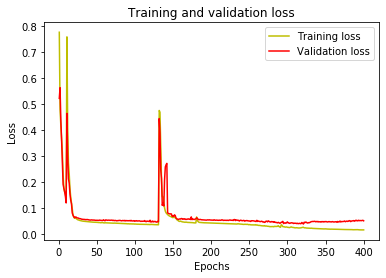

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

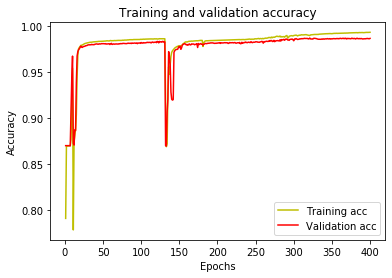

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
img_no = 2
img = X_do_not_use[img_no]
img = np.reshape(img,(1,512,512,3))
print(img.shape)
# img = normalize(img)

pred = model.predict(img)

(1, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


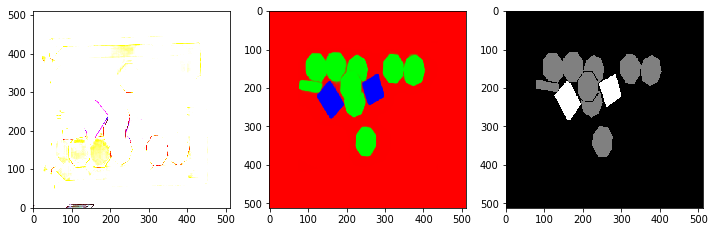

In [25]:
from matplotlib import colors, cm, pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(131)
img = np.reshape(X_do_not_use[img_no], (512, 512,3))
norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
plt.imshow(img*125, cmap=cm.gray, norm=norm, origin="lower")

# plt.imshow(np.reshape(X_do_not_use[img_no], (512, 512,3))*100)
plt.subplot(132)
plt.imshow(np.reshape(pred, (512, 512,3)), cmap='gray')
plt.subplot(133)
plt.imshow(np.reshape(y_do_not_use[img_no], (512, 512)), cmap='gray')
plt.show()
#print(X_train[image_number])